In [43]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import time

In [13]:
# Pra rodar no colab caso seja util (Tem que ter os dados de treino no drive)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
# Caminho da pasta que você quer compactar no seu Drive
pasta_para_compactar = '/content/drive/MyDrive/treino'

# Nome do arquivo .zip que será criado no seu Drive
nome_do_zip_final = '/content/drive/MyDrive/treino.zip'

# O comando -r (recursivo) garante que tudo dentro da pasta será incluído
!zip -r '{nome_do_zip_final}' '{pasta_para_compactar}'

print(f"Pasta compactada com sucesso! O arquivo '{nome_do_zip_final}")

Streaming output truncated to the last 5000 lines.
  adding: content/drive/MyDrive/treino/CLEOPATRA/Image_6057.jpg (deflated 1%)
  adding: content/drive/MyDrive/treino/CLEOPATRA/Image_6142.jpg (deflated 1%)
  adding: content/drive/MyDrive/treino/CLEOPATRA/Image_6141.jpg (deflated 1%)
  adding: content/drive/MyDrive/treino/CLEOPATRA/Image_6248.jpg (deflated 1%)
  adding: content/drive/MyDrive/treino/CLEOPATRA/Image_6079.jpg (deflated 1%)
  adding: content/drive/MyDrive/treino/CLEOPATRA/Image_6214.jpg (deflated 1%)
  adding: content/drive/MyDrive/treino/CLEOPATRA/Image_6270.jpg (deflated 1%)
  adding: content/drive/MyDrive/treino/CLODIUS PARNASSIAN/ (stored 0%)
  adding: content/drive/MyDrive/treino/CLODIUS PARNASSIAN/Image_393.jpg (deflated 1%)
  adding: content/drive/MyDrive/treino/CLODIUS PARNASSIAN/Image_476.jpg (deflated 1%)
  adding: content/drive/MyDrive/treino/CLODIUS PARNASSIAN/Image_305.jpg (deflated 1%)
  adding: content/drive/MyDrive/treino/CLODIUS PARNASSIAN/Image_455.jpg (d

In [38]:
# Defina o caminho para o seu arquivo .zip no Google Drive
zip_path_in_drive = '/content/drive/MyDrive/treino.zip'  # <-- MUDE AQUI para o caminho e nome corretos

# Copia o arquivo para o disco local do Colab
!cp '{zip_path_in_drive}' /content/

print(f"Arquivo '{zip_path_in_drive.split('/')[-1]}' copiado com sucesso para o ambiente do Colab.")

Arquivo 'treino.zip' copiado com sucesso para o ambiente do Colab.


In [39]:
import os

# Nome do arquivo zip que foi copiado
zip_name = 'treino.zip'  # <-- MUDE AQUI se o nome do seu arquivo for diferente

# Descompacta o arquivo no diretório /content/dataset_local/
# O comando -q (quiet) evita mostrar a lista de todos os arquivos descompactados
!unzip -q /content/{zip_name} -d /content/dataset_local/

print("Dataset descompactado com sucesso no diretório local '/content/dataset_local/'.")

Dataset descompactado com sucesso no diretório local '/content/dataset_local/'.


In [44]:
# Para checar se a GPU do colab está ativa
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# Para pegar as imagens direto do kaggle
import kagglehub

# Download latest version
path = kagglehub.dataset_download("phucthaiv02/butterfly-image-classification")

print("Path to dataset files:", path)

In [91]:
train_ds = keras.utils.image_dataset_from_directory(
    r'/content/dataset_local/content/drive/MyDrive/treino', # A localização da pasta
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    shuffle=True,
    validation_split=0.1,
    subset="training",
    seed = 123)

validation_ds = keras.utils.image_dataset_from_directory(
    r'/content/dataset_local/content/drive/MyDrive/treino', # A localização da pasta
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    shuffle=True,
    validation_split=0.1,
    subset="validation",
    seed = 123)

# Passar 60 baches de treino para teste
test_ds = train_ds.take(60)
train_ds = train_ds.skip(60)


Found 6499 files belonging to 75 classes.
Using 5850 files for training.
Found 6499 files belonging to 75 classes.
Using 649 files for validation.


In [92]:
# Em bachts de 32
print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {validation_ds.cardinality()}")
print(f'Number of testing samples: {test_ds.cardinality()}')

Number of training samples: 123
Number of validation samples: 21
Number of testing samples: 60


In [94]:
resize_fn = keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))


In [49]:
# Tirando das batchs para fazer data augmentation
train_ds = train_ds.unbatch()

augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x

def augment_image(image, label):
    """
    Applies data augmentation and creates multiple versions of an image.
    """

    image_versions = [image] # Essa lista vai conter todas as diferentes versões da imagem, começando com a original

    for _ in range(4): # Cada imagem vai virar 5 (contando com ela mesma)
        augmented_image = image
        for layer in augmentation_layers:
            # Tem que ter o training = True para garantir que ele vai aplicar as camadas de augmentation
            augmented_image = layer(augmented_image, training=True)
        image_versions.append(augmented_image) # Guarda as imagens modificadas na mesma lista

    images_tensor = tf.stack(image_versions) # Transforma a lista em um tensor


    labels_tensor = tf.repeat(label, repeats = 5) # Repetindo as labels para ficar igual

    # Tem que retornar um tensor para o flat_map
    return tf.data.Dataset.from_tensor_slices((images_tensor, labels_tensor))


train_ds = train_ds.flat_map(augment_image)
train_ds = train_ds.batch(32)


In [50]:
# Em bachts de 32

print(f"Number of training samples: {len(list(train_ds))}")
# Agora a gente tem 615 batches (5 vezes mais que antes), quando usamos o flat_map o keras para de ficar sabendo quantos batches tem diretamente pelo .cardinality()

print(f"Number of validation samples: {validation_ds.cardinality()}")
print(f'Number of testing samples: {test_ds.cardinality()}')

KeyboardInterrupt: 

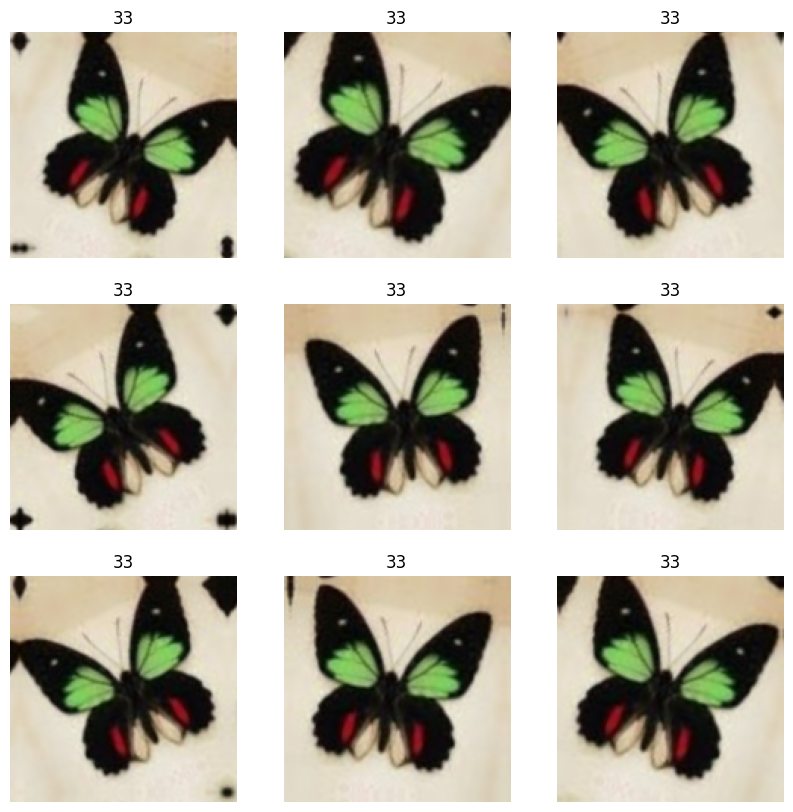

In [51]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [52]:
base_model_com_pretreino = keras.applications.Xception(
    weights="imagenet",  # Carregando os pesos do modelo pré-treinado no dataset imaginet.
    input_shape=(150, 150, 3),
    include_top=False,  # Tirar o classificador final do modelo
) # O imaginet 1000 utilizado contém 5 espécies de borboletas (ringlet, monarch, cabbage, sulphur, lycaenid) e só monarch e cabbage aparecem no nosso dataset.

# Congelando o modelo base
base_model_com_pretreino.trainable = False

# O input do modelo
inputs = keras.Input(shape=(150, 150, 3))

# O Xception pré treinado requer que os insputs tenham essa escala.
# de (0, 255) para (-1., +1.).
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

x = base_model_com_pretreino(x, training=False) # Passar o training = False para deixar o batchnorming layer do base_model em modo inferência.


x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularizar com dropout

outputs = keras.layers.Dense(75, activation="softmax")(x) # saída com 75 classes pois temos 75 espécies de borboletas no dataset.

# Criar o modelo final
model_com_pretreino = keras.Model(inputs, outputs)

model_com_pretreino.compile(
    optimizer=keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)


model_com_pretreino.summary(show_trainable=True)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_11 (InputLayer) │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling_4 (Rescaling)     │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_4  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_8 (Dropout)         │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_10 (Dense)            │ (None, 75)            │    153,675 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 21,015,155 (80.17 MB)

 Trainable params: 153,675 (600.29 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [53]:
base_model_sem_pretreino = keras.applications.Xception(
    weights=None,  # Não carregar os pesos do modelo pré-treinado no dataset imaginet.
    input_shape=(150, 150, 3),
    include_top=False,  # Tirar o classificador final do modelo
) # O imaginet 1000 utilizado contém 5 espécies de borboletas (ringlet, monarch, cabbage, sulphur, lycaenid) e só monarch e cabbage aparecem no nosso dataset.

# Não precisa congelar o modelo dessa vez

# O input do modelo
inputs = keras.Input(shape=(150, 150, 3))

# O Xception requer que os insputs tenham essa escala.
# de (0, 255) para (-1., +1.).
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

x = base_model_sem_pretreino(x, training=False) # Passar o training = False para deixar o batchnorming layer do base_model em modo inferência.


x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularizar com dropout

outputs = keras.layers.Dense(75, activation="softmax")(x) # saída com 75 classes pois temos 75 espécies de borboletas no dataset.

# Criar o modelo final
model_sem_pretreino = keras.Model(inputs, outputs)

model_sem_pretreino.compile(
    optimizer=keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)


model_sem_pretreino.summary(show_trainable=True)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_13 (InputLayer) │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling_5 (Rescaling)     │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)    │ 20,861,480 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_5  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_9 (Dropout)         │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_11 (Dense)            │ (None, 75)            │    153,675 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 21,015,155 (80.17 MB)

 Trainable params: 20,960,627 (79.96 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [54]:
inputs = keras.Input(shape=(150, 150, 3))

# Parte Convolucional

# Conv 1
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x) # Pega janelas 2x2 e tira o maximo (reduz a imagem pela metade)

# Conv 2
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

# Conv 3
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

# Conv 4
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

# Conv 5
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)

# Achatamos a saída do bloco convolucional para um vetor 1D
x = layers.Flatten()(x)

# --- Parte Densa

# Dense 1
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x) # Dropout para regularização

# Dense 2
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x) # Dropout para regularização

# Dense 3 (Camada de Saída)
outputs = layers.Dense(75, activation="softmax")(x)

# --- Criação e Compilação do Modelo ---
model_mini = keras.Model(inputs=inputs, outputs=outputs)

model_mini.compile(
    optimizer=keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model_mini.summary(show_trainable=True)

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_14 (InputLayer) │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_34 (Conv2D)          │ (None, 150, 150, 32)  │        896 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_8             │ (None, 75, 75, 32)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_35 (Conv2D)          │ (None, 75, 75, 64)    │     18,496 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_9             │ (None, 37, 37, 64)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_36 (Conv2D)          │ (None, 37, 37, 128)   │     73,856 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_10            │ (None, 18, 18, 128)   │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_37 (Conv2D)          │ (None, 18, 18, 128)   │    147,584 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_11            │ (None, 9, 9, 128)     │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_38 (Conv2D)          │ (None, 9, 9, 256)     │    295,168 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_2 (Flatten)         │ (None, 20736)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_12 (Dense)            │ (None, 512)           │ 10,617,344 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_10 (Dropout)        │ (None, 512)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_13 (Dense)            │ (None, 256)           │    131,328 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_11 (Dropout)        │ (None, 256)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_14 (Dense)            │ (None, 75)            │     19,275 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 11,303,947 (43.12 MB)

 Trainable params: 11,303,947 (43.12 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# Callback para pegar os tempos

class TimingCallback(tf.keras.callbacks.Callback):
    """Callback para registrar o tempo gasto em cada época."""

    def __init__(self, logs={}):
        self.times = [] # Lista para armazenar os tempos de cada época

    def on_epoch_begin(self, epoch, logs={}):
        """É chamado no início de uma época."""
        self.starttime = time.time() # Registra o tempo de início

    def on_epoch_end(self, epoch, logs={}):
        """É chamado no final de uma época."""
        # Calcula a duração e adiciona à lista
        duration = time.time() - self.starttime
        self.times.append(duration)

time_callback_com_pretreino = TimingCallback()
time_callback_sem_pretreino = TimingCallback()
time_callback_mini_modelo = TimingCallback()

In [56]:
# Pode ficar aparecendo Unknown  na quantidade de bathces por conta do data augmentation mas é 615
epochs = 10
print("Fitando o modelo com pretreino")
history_com_pretreino = model_com_pretreino.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks=[time_callback_com_pretreino])
print("Fitando o modelo sem pretreino")
history_sem_pretreino = model_sem_pretreino.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks=[time_callback_sem_pretreino])
print("Fitando o mini modelo")
history_mini_modelo = model_mini.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks=[time_callback_mini_modelo])

Fitando o modelo com pretreino
Epoch 1/10
    615/Unknown 119s 176ms/step - accuracy: 0.3873 - loss: 2.6506

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


615/615 ━━━━━━━━━━━━━━━━━━━━ 136s 203ms/step - accuracy: 0.3876 - loss: 2.6492 - val_accuracy: 0.7072 - val_loss: 0.9826
Epoch 2/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 100s 158ms/step - accuracy: 0.7529 - loss: 0.8376 - val_accuracy: 0.7704 - val_loss: 0.8008
Epoch 3/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 100s 160ms/step - accuracy: 0.8078 - loss: 0.6488 - val_accuracy: 0.7889 - val_loss: 0.7468
Epoch 4/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 100s 159ms/step - accuracy: 0.8391 - loss: 0.5349 - val_accuracy: 0.7766 - val_loss: 0.7566
Epoch 5/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 102s 162ms/step - accuracy: 0.8671 - loss: 0.4294 - val_accuracy: 0.7982 - val_loss: 0.6856
Epoch 6/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 101s 161ms/step - accuracy: 0.8723 - loss: 0.4019 - val_accuracy: 0.8074 - val_loss: 0.7032
Epoch 7/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 102s 162ms/step - accuracy: 0.8847 - loss: 0.3675 - val_accuracy: 0.7904 - val_loss: 0.7115
Epoch 8/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 100s 160ms/step - accuracy: 0.8978 - loss: 0.31

In [57]:
# Extrair os dados do objeto history
acc_com_pretreino = history_com_pretreino.history['accuracy']
val_acc_com_pretreino = history_com_pretreino.history['val_accuracy']
loss_com_pretreino = history_com_pretreino.history['loss']
val_loss_com_pretreino = history_com_pretreino.history['val_loss']
epoch_times_com_pretreino = time_callback_com_pretreino.times
epochs_range_com_pretreino = range(1, len(acc_com_pretreino) + 1) # Só para não começar do 0

In [58]:
# Extrair os dados do objeto history
acc_sem_pretreino = history_sem_pretreino.history['accuracy']
val_acc_sem_pretreino = history_sem_pretreino.history['val_accuracy']
loss_sem_pretreino = history_sem_pretreino.history['loss']
val_loss_sem_pretreino = history_sem_pretreino.history['val_loss']
epoch_times_sem_pretreino = time_callback_sem_pretreino.times
epochs_range_sem_pretreino = range(1, len(acc_sem_pretreino) + 1) # Só para não começar do 0

In [64]:
# Extrair os dados do objeto history
acc_mini_modelo = history_mini_modelo.history['accuracy']
val_acc_mini_modelo = history_mini_modelo.history['val_accuracy']
loss_mini_modelo = history_mini_modelo.history['loss']
val_loss_mini_modelo = history_mini_modelo.history['val_loss']
epoch_times_mini_modelo = time_callback_mini_modelo.times
epochs_range_mini_modelo = range(1, len(acc_mini_modelo) + 1) # Só para não começar do 0

In [62]:
epochs_range = epochs_range_com_pretreino # Todas são iguais

ValueError: x and y must have same first dimension, but have shapes (10,) and (30,)

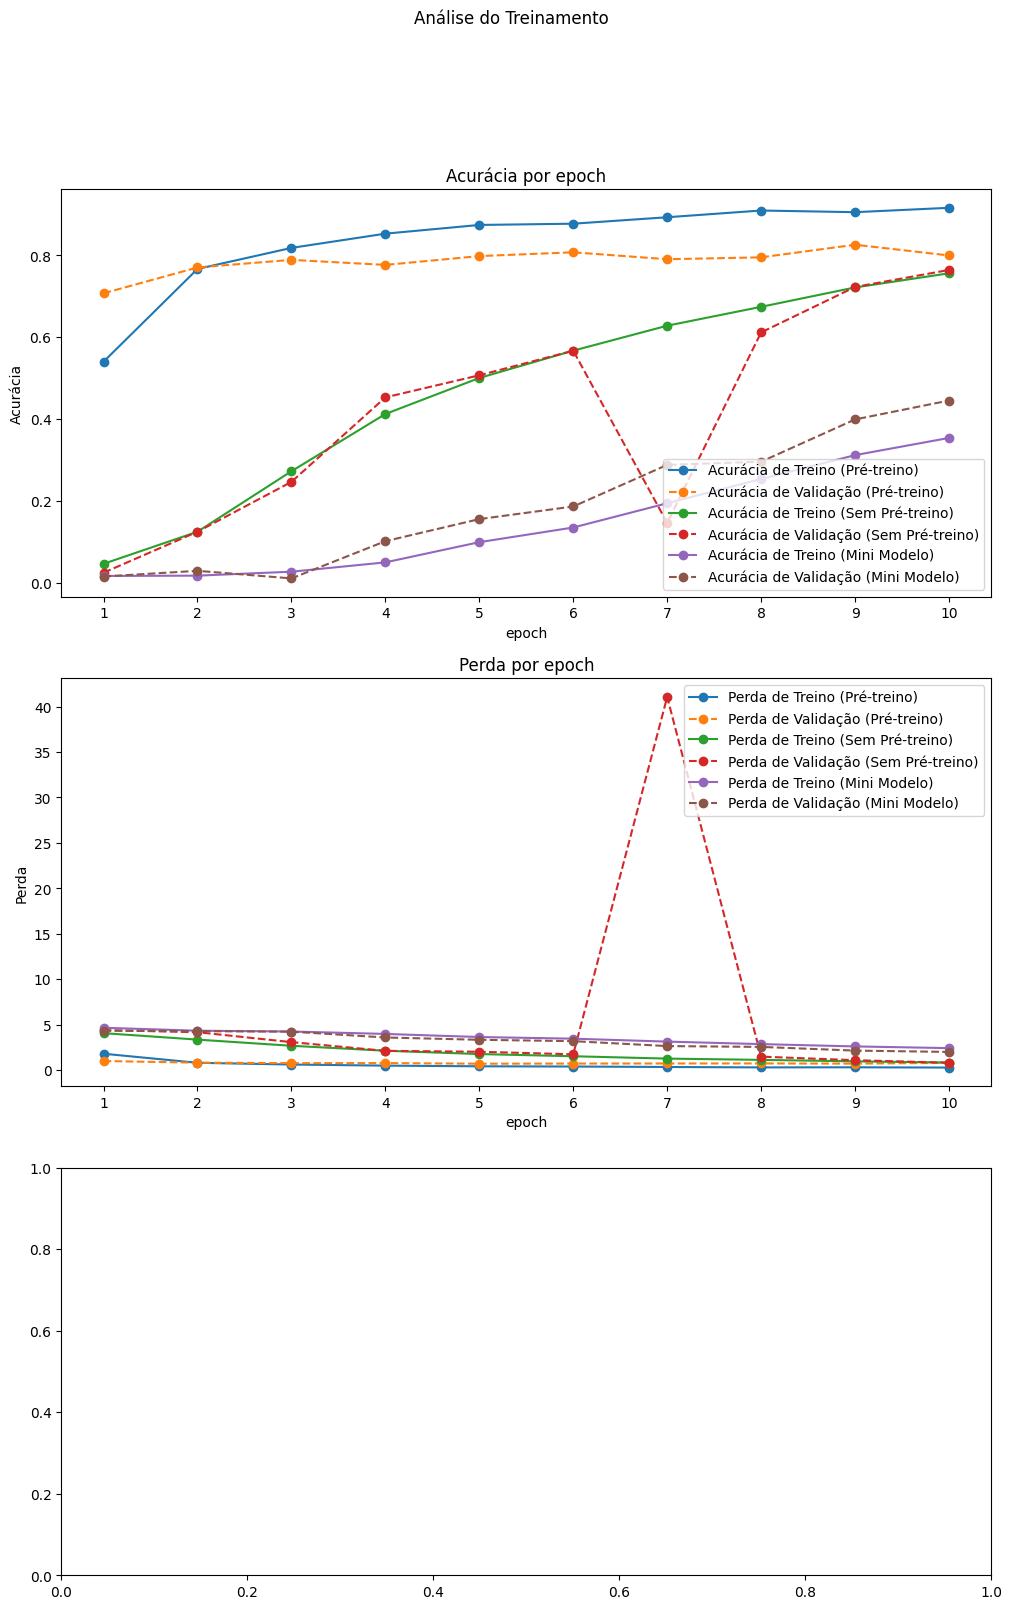

In [75]:
# Criar a figura e os eixos para os plots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))
fig.suptitle('Análise do Treinamento')

# Plot 1: Acurácia de Treino e Validação
ax1.plot(epochs_range, acc_com_pretreino, 'o-', label='Acurácia de Treino (Pré-treino)')
ax1.plot(epochs_range, val_acc_com_pretreino, 'o--', label='Acurácia de Validação (Pré-treino)')
ax1.plot(epochs_range, acc_sem_pretreino, 'o-', label='Acurácia de Treino (Sem Pré-treino)')
ax1.plot(epochs_range, val_acc_sem_pretreino, 'o--', label='Acurácia de Validação (Sem Pré-treino)')
ax1.plot(epochs_range, acc_mini_modelo, 'o-', label='Acurácia de Treino (Mini Modelo)')
ax1.plot(epochs_range, val_acc_mini_modelo, 'o--', label='Acurácia de Validação (Mini Modelo)') # Corrected variable name


ax1.set_title('Acurácia por epoch')
ax1.set_xlabel('epoch')
ax1.set_ylabel('Acurácia')
ax1.legend(loc='lower right') # Para não atrapalhar o gráfico
ax1.set_xticks(epochs_range)

# Plot 2: Perda de Treino e Validação
ax2.plot(epochs_range, loss_com_pretreino, 'o-', label='Perda de Treino (Pré-treino)')
ax2.plot(epochs_range, val_loss_com_pretreino, 'o--', label='Perda de Validação (Pré-treino)')
ax2.plot(epochs_range, loss_sem_pretreino, 'o-', label='Perda de Treino (Sem Pré-treino)')
ax2.plot(epochs_range, val_loss_sem_pretreino, 'o--', label='Perda de Validação (Sem Pré-treino)')
ax2.plot(epochs_range, loss_mini_modelo, 'o-', label='Perda de Treino (Mini Modelo)')
ax2.plot(epochs_range, val_loss_mini_modelo, 'o--', label='Perda de Validação (Mini Modelo)') # Corrected variable name


ax2.set_title('Perda por epoch')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Perda')
ax2.legend(loc='upper right')
ax2.set_xticks(epochs_range)

# Plot 3: Tempo por Epoch
ax3.plot(epochs_range, epoch_times_com_pretreino, 'o-', label='Tempo por Epoch (Pré-treino)')
ax3.plot(epochs_range, epoch_times_sem_pretreino, 'o--', label='Tempo por Epoch (Sem Pré-treino)')
ax3.plot(epochs_range, epoch_times_mini_modelo, label='Tempo por Epoch (Mini Modelo)')

ax3.set_title('Tempo por epoch')
ax3.set_xlabel('epoch')
ax3.set_ylabel('Tempo (segundos)')
ax3.legend()
ax3.set_xticks(epochs_range)

# Ajustar o layout para evitar sobreposição de títulos e rótulos
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta o layout, deixando espaço para o suptitle

# Mostrar o plot
plt.show()

In [78]:
print("Train dataset evaluation")
model_mini.evaluate(train_ds)
model_sem_pretreino.evaluate(train_ds) # -> Loss, accuracy
model_com_pretreino.evaluate(train_ds)

Test dataset evaluation
615/615 ━━━━━━━━━━━━━━━━━━━━ 79s 125ms/step - accuracy: 0.4505 - loss: 1.9495


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


615/615 ━━━━━━━━━━━━━━━━━━━━ 102s 163ms/step - accuracy: 0.8195 - loss: 0.6222
615/615 ━━━━━━━━━━━━━━━━━━━━ 101s 162ms/step - accuracy: 0.9212 - loss: 0.2642


[0.19455866515636444, 0.9372010231018066]

In [95]:
print("Test dataset evaluation")
model_mini.evaluate(test_ds)
model_sem_pretreino.evaluate(test_ds) # -> Loss, accuracy
model_com_pretreino.evaluate(test_ds)

Test dataset evaluation
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.4476 - loss: 2.0162
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.7770 - loss: 0.8506
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.8075 - loss: 0.7878


[0.7393761277198792, 0.8109375238418579]